In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import model_selection,preprocessing
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,LabelBinarizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.naive_bayes import MultinomialNB
from gensim.sklearn_api import D2VTransformer
from sklearn.model_selection import cross_val_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import AdaBoostClassifier
from scipy import stats
from scipy.stats import randint
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifierCV
import multiprocessing
import gensim
from gensim.models.doc2vec import TaggedDocument
cores = multiprocessing.cpu_count()
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
import numpy as np

from lightgbm import LGBMClassifier

In [10]:
df = pd.read_csv("emotion.data")
#ff = pd.read_csv("text_emotion.csv")

In [11]:
df.rename(columns = {'emotions':'label'},inplace = True)

In [12]:
len(df)

416809

In [ ]:
def stem_text(word_list):  #Lemmatize text
    new_list = []
    for word in word_list:
        wl = PorterStemmer()
        rootword=wl.stem(word)
        new_list.append(rootword)
    return new_list


def remove_stopwords(row):     #Remove Stopwords from text
    tokens = word_tokenize(row)
    filtered_word = [word for word in tokens if not word in stop_words]
    stemmed_text = stem_text(filtered_word)
    return stemmed_text


def make_string(row):      #Convert list into string
    new = ''
    for word in row:
        new = new + word
        new = new + ' '
    return new


def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

df['statement_clean'] = ''
df['statement_clean'] = df['text'].apply(lambda x: x.lower())
df['statement_clean'] = df['statement_clean'].map(lambda x:clean_text(x))
stop_words = set(stopwords.words('english'))
df['statement_clean'] = df['statement_clean'].apply(remove_stopwords)
df['statement_clean'] = df['statement_clean'].apply(make_string)
df['statement_clean'].replace(to_replace = '[^\w\s]',value='',inplace = True,regex = True )  #Remove punctuation
df['statement_clean'].replace(to_replace = '[\d]',value='',inplace = True,regex = True )     #Remove digits
df['statement_clean'] = df['statement_clean'].apply(lambda x:" ".join(x.split()))            #Remove duplicate white spaces
df['statement_clean'] = df['statement_clean'].apply(lambda x:" ".join(word for word in x.split(' ') if len(word) > 3))   #Remove single letter words
print(df['statement_clean'])


In [7]:
encoder = preprocessing.LabelEncoder()
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['statement_clean'],df['label'])

train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer()
#tfidf_vect.fit(df['statement_clean'])
xtrain_tfidf = tfidf_vect.fit_transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)




In [8]:
xtrain_tfidf.shape

(312606, 41733)

[('gentl', 'romant', 'nostalg', 'naughti', 'tender', 'horni', 'love', 'sympathet', 'irrit', 'strang', 'overwhelm', 'stun', 'weird', 'surpris', 'funni', 'daze', 'impress', 'shock', 'curiou', 'amaz'), (3776.321261882601, 3810.348201469146, 4057.1665365291283, 4065.803986897712, 4328.660790181107, 4357.406134428423, 4363.912910152591, 4702.620415318472, 5102.612442662721, 5227.1190090762675, 5231.463541344223, 5568.800650644049, 5917.613282933125, 7610.407855695803, 8130.984155301751, 8130.993379894885, 9475.275881784073, 9808.399074905763, 10225.07575615623, 10503.310823266986)]


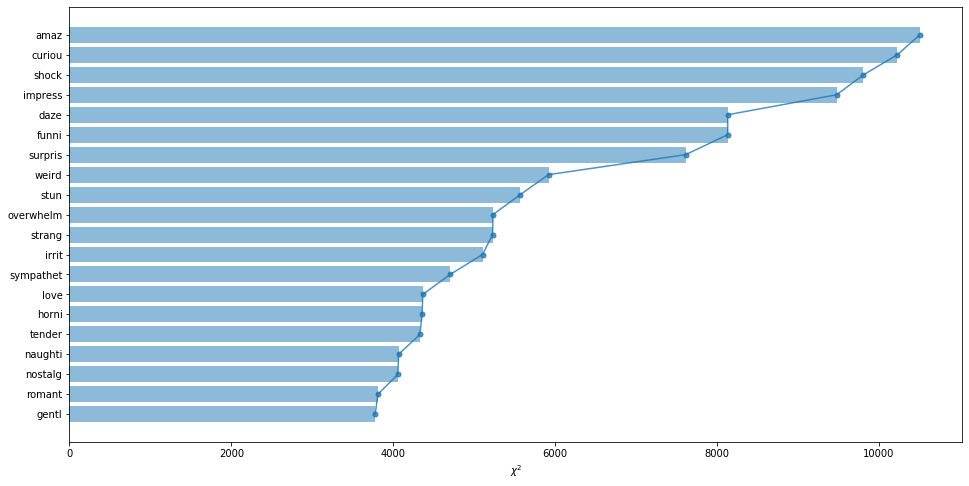

In [9]:
chi2score=chi2(xtrain_tfidf,train_y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_vect.get_feature_names(), chi2score))
chi2_ = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2_[-20:]))
print(topchi2)
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show()

In [10]:
chi2_features = SelectKBest(chi2, k = 10000) 
xtrain_tfidf = chi2_features.fit_transform(xtrain_tfidf, train_y) 
xvalid_tfidf = chi2_features.transform(xvalid_tfidf)

In [ ]:
params = {
    'multi_class': 'ovr',
    'solver': 'lbfgs'
}

lgbm_params = {
    'n_estimators': 250,
    'max_depth': 10,
    'learning_rate': 0.03,
    'objective': 'multiclass',
    'n_jobs': cores,
    'boosting_type':'dart',
    'num_leaves':1024,
    
    
}

clf = LGBMClassifier(**lgbm_params)
#clf = LogisticRegression(**params)#clf = MultinomialNB().fit(xtrain_tfidf.toarray(),train_y)
#clf = XGBClassifier()
clf.fit(xtrain_tfidf, train_y)
print(clf)

#clf = MultinomialNB().fit(xtrain_tfidf.toarray(),train_y)

In [ ]:
predictions = clf.predict(xvalid_tfidf)
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(valid_y, predictions)
print ('Accuracy Score :',accuracy_score(valid_y, predictions))
print ('Report : ')
print (classification_report(valid_y,predictions))